# Кластеризация ЕГЭ (4 если сделаны все задачи)

Рядом лежат данные с координатами точек. Везде используется Евклидово расстояние. Кластером считается набор не менее чем из 30 точек связанных друг с другом. Аномалия это точка находящаяся на расстоянии более 1 от любого кластера.

* Постройте Распределение точек
* Напишите руками DBSCAN и обработайте им все файлы
* Файл 0.xls также решите руками
* Постройте Распределение точек, отметьте принадлежность кластеров цветами
* Отметьте Аномалии отдельным цветом
* Найдите среди в каждом кластере точку расстояние от которой до всех остальных минимально
* Выведите два числа - Среднее абсцисс и ординат центроидов кластеров * 100000

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Функция чтения файла '.txt'

In [24]:
def f(file_name):
    data = []
    i = 0
    with open(file_name, "r") as file:
        for line in file:
            if i == 0:
                i = 1
                continue
            line = line.strip()
            if line:
                values = line.split(',')
                p = [float(values[0].strip()), float(values[1].strip())]
                data.append(p)
    return data

Отображение исходных данных

In [42]:
def show_data(data):
    x = [p[0] for p in data]
    y = [p[1] for p in data]
    plt.figure(figsize=(10, 6))
    if (len(data) > 1000):
        plt.scatter(x, y, color='gray', s=1)  # s=1 – маленький размер точек
    else:
        for point in data:
            plt.scatter(point[0], point[1], color='gray')
    plt.title('Исходные данные')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

Реализуем подбор параметров $minPts$ - минимальное количество соседей и $eps$ - минимальный радиус окружности, в которой будет идти поиск соседей

In [34]:
from sklearn.neighbors import NearestNeighbors
def find_parametrs(data, x_coords, y_coords):
    # Строим модель ближайших соседей
    neighbors = NearestNeighbors(n_neighbors=4)  #minPts = 4
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)

    # Берём расстояния до 4-го соседа (индекс 3, так как индексация с нуля)
    k_distances = sorted(distances[:, 3])

    # Строим график
    plt.figure(figsize=(10, 6))
    plt.plot(k_distances)
    plt.plot(x_coords, y_coords, linestyle='--', color='red')
    plt.title("График k-ближайших расстояний (k-distance plot)")
    plt.xlabel("Индекс точки (отсортированный)")
    plt.ylabel("Расстояние до 5-го соседа")
    plt.grid(True)
    plt.show()


Реализация DBSCAN

In [26]:
from math import dist

def dbscan(data, eps, minPts):
    n = len(data)              # число точек
    result = [None] * n        # создаём список меток для точек (None — не посещены)
    cluster = 0             # текущий номер кластера

    for id in range(n):
        if result[id] is not None:
            continue
        neighbors = [j for j in range(n) if dist(data[id], data[j]) <= eps] #найдем всех соседей точки на расстоянии <= eps

        if len(neighbors) < minPts:
            result[id] = -1 #решаем, является ли точка ядром кластера
            continue

        cluster += 1              # создаём новый кластер
        result[id] = cluster      # помечаем точку как ядро нового кластера
        q = neighbors            # создаём очередь для расширения кластера

        while q:
            j = q.pop()
            if result[j] is None:
                result[j] = cluster
                new_neighbors = [k for k in range(n) if dist(data[j], data[k]) <= eps]
                if len(new_neighbors) >= minPts:
                    q.extend(new_neighbors)
            elif result[j] == -1:
                result[j] = cluster

    return result

Отображение результата

In [ ]:
def show_result(labels, data, point_size=10, alpha=0.7):
    data = np.array(data)
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    
    # Базовый набор цветов (можно расширить)
    colors = ['blue', 'green', 'orange', 'purple', 'brown', 'red']
    
    plt.figure(figsize=(10, 6))
    
    for label in unique_labels:
        mask = (labels == label)
        if label == -1:
            # Шум – чёрным цветом
            plt.scatter(data[mask, 0], data[mask, 1],
                       color='black', s=point_size, alpha=alpha, label='Шум')
        else:
            # Выбираем цвет по остатку от деления (чтобы не выйти за границы списка)
            color = colors[label % len(colors)]
            plt.scatter(data[mask, 0], data[mask, 1],
                       color=color, s=point_size, alpha=alpha, label=f'Кластер {label}')
    
    plt.title("Результат кластеризации DBSCAN")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.legend()
    plt.show()

In [128]:
from collections import defaultdict
import math
def cluster_points(data, labels): #Группирует точки по меткам кластеров (исключая шум -1)
    clusters = defaultdict(list)
    for point, label in zip(data, labels):
        if label != -1:
            clusters[label].append(point)
    return clusters

def find_medoid(cluster_pts): #Возвращает точку (медоид) с минимальной суммой расстояний до остальных в кластере
    best_point = None
    best_sum = float('inf')
    for i, p in enumerate(cluster_pts):
        total = 0.0
        for j, q in enumerate(cluster_pts):
            if i != j:
                total += math.dist(p, q)
        if total < best_sum:
            best_sum = total
            best_point = p
    return best_point

def cluster_centroids(clusters):
    centroids = []
    for pts in clusters.values():
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]
        centroids.append((sum(xs)/len(pts), sum(ys)/len(pts)))
    return centroids

**Работа с файлом '2.txt'**

In [ ]:
data2 = f("2.txt")     
print(f("2.txt"))

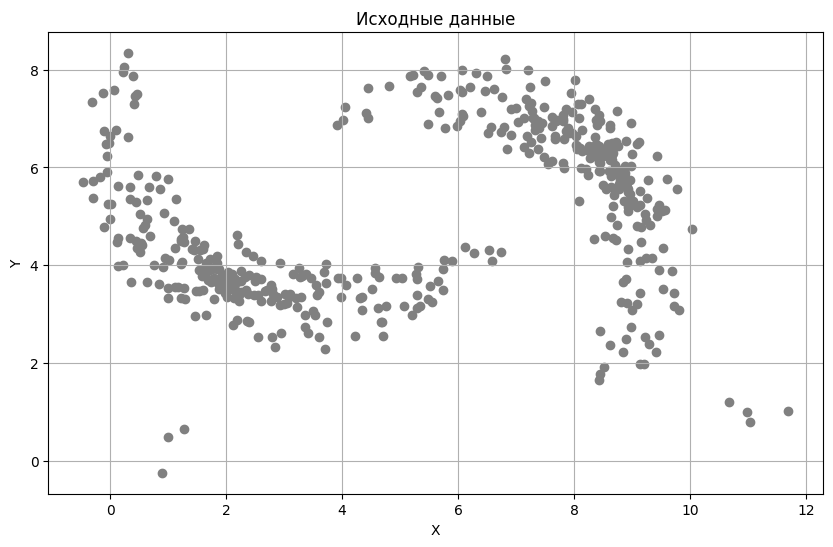

In [ ]:
show_data(data2)

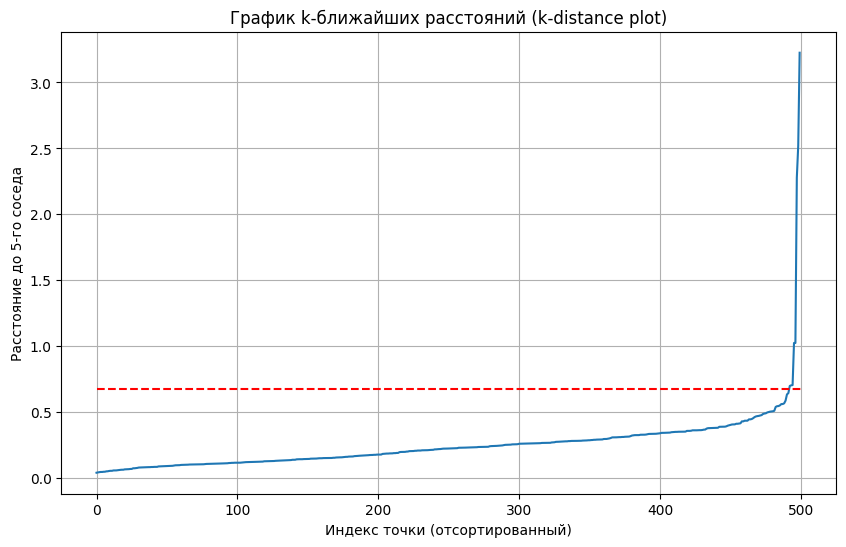

In [ ]:
x_coords = [0, 500]
y_coords = [0.67, 0.67]
find_parametrs(data2, x_coords, y_coords)

In [126]:
labels2 = dbscan(data2, 0.67, 4)

In [ ]:
print(labels2)

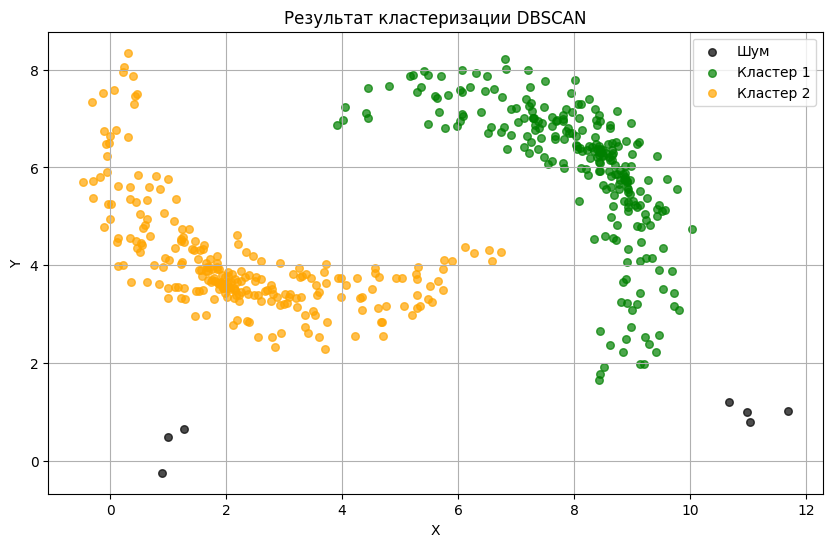

In [ ]:
show_result(labels2, data2, point_size=30)

In [129]:
clusters = cluster_points(data2, labels2)
print("Медоиды кластеров:")
for label, pts in clusters.items():
    med = find_medoid(pts)
    print(f"Кластер {label}: {med}")

centroids = cluster_centroids(clusters)
if centroids:
    avg_x = sum(c[0] for c in centroids) / len(centroids)
    avg_y = sum(c[1] for c in centroids) / len(centroids)
    print(f"Среднее центроидов * 100000: {avg_x*100000:.6f}, {avg_y*100000:.6f}")
else:
    print("Нет кластеров (только шум)")

Медоиды кластеров:
Кластер 1: [8.279901088686108, 6.194730492566545]
Кластер 2: [2.0387619757963513, 3.7850114170985236]
Среднее центроидов * 100000: 513604.216545, 503167.671986


**Работа с файлом '3.txt'**

In [ ]:
data3 = f("3.txt")     
print(f("3.txt"))

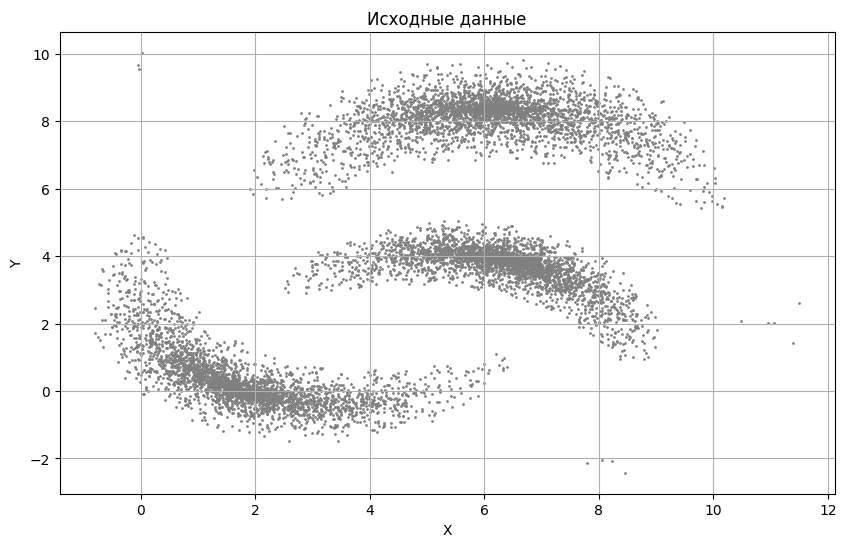

In [ ]:
show_data(data3)

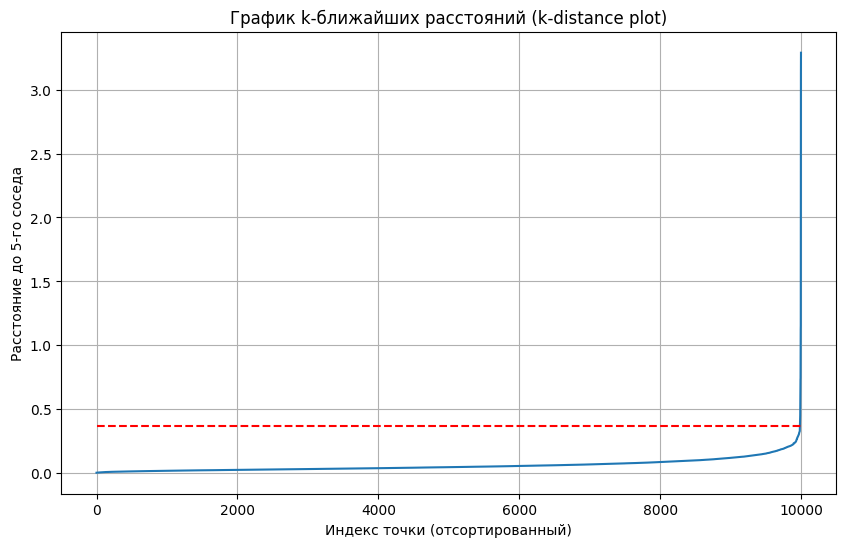

In [ ]:
x_coord = [0, len(data3)]
y_coord = [0.37, 0.37]
find_parametrs(data3, x_coord, y_coord)

In [131]:
labels3 = dbscan(data3, 0.37, 4)

In [ ]:
print(labels3)

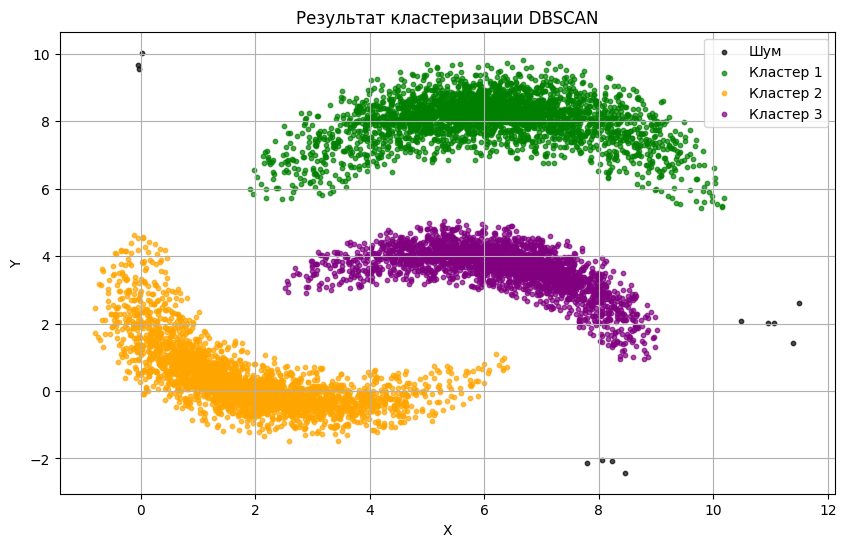

In [ ]:
show_result(labels3, data3)

In [132]:
clusters = cluster_points(data3, labels3)
print("Медоиды кластеров:")
for label, pts in clusters.items():
    med = find_medoid(pts)
    print(f"Кластер {label}: {med}")

centroids = cluster_centroids(clusters)
if centroids:
    avg_x = sum(c[0] for c in centroids) / len(centroids)
    avg_y = sum(c[1] for c in centroids) / len(centroids)
    print(f"Среднее центроидов * 100000: {avg_x*100000:.6f}, {avg_y*100000:.6f}")
else:
    print("Нет кластеров (только шум)")

Медоиды кластеров:
Кластер 1: [6.0972760336772325, 8.290449940374414]
Кластер 2: [1.696151015672141, 0.12926250793867355]
Кластер 3: [6.338891180086092, 3.8563329929926073]
Среднее центроидов * 100000: 472968.612664, 404287.740634


**Работа с файлом '4.txt'**

In [ ]:
data4 = f('4.txt')
print(data4)

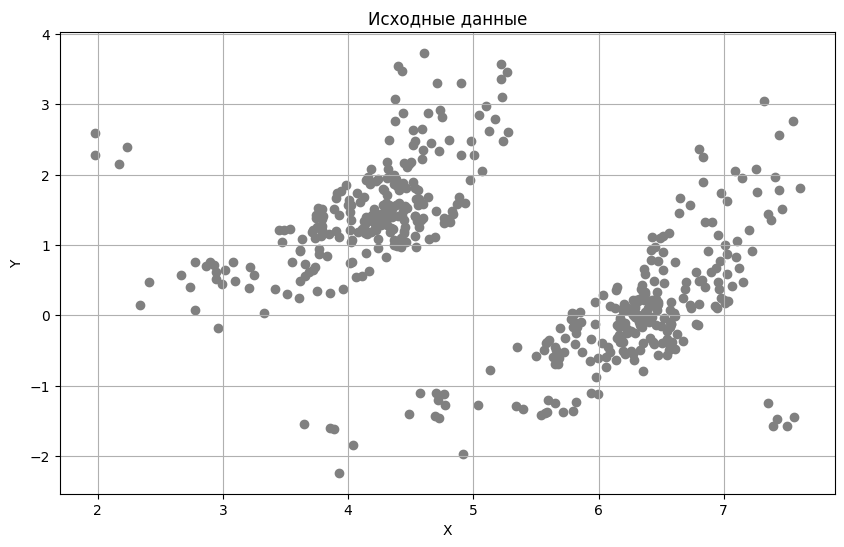

In [110]:
show_data(data4)

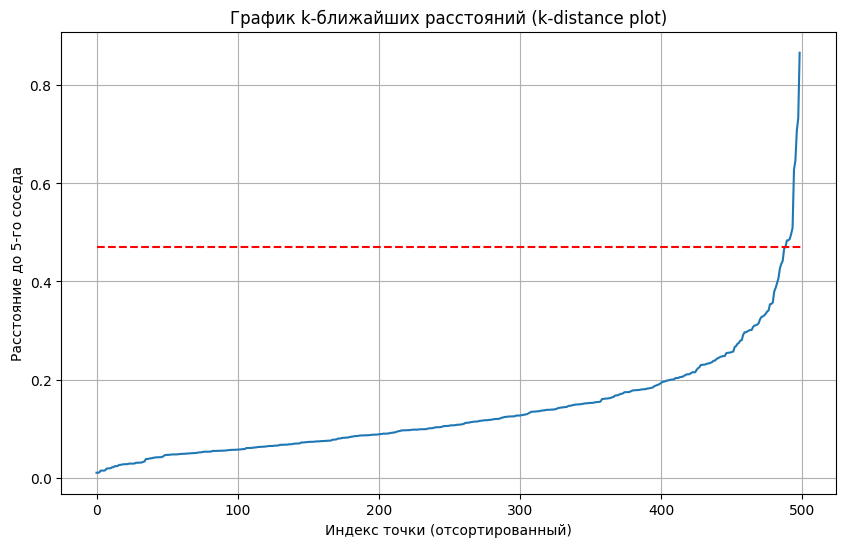

In [112]:
x_coord = [0, len(data4)]
y_coord = [0.47, 0.47]
find_parametrs(data4, x_coord, y_coord)

In [ ]:
labels4 = dbscan(data4, 1.0, 6)
print(labels4)

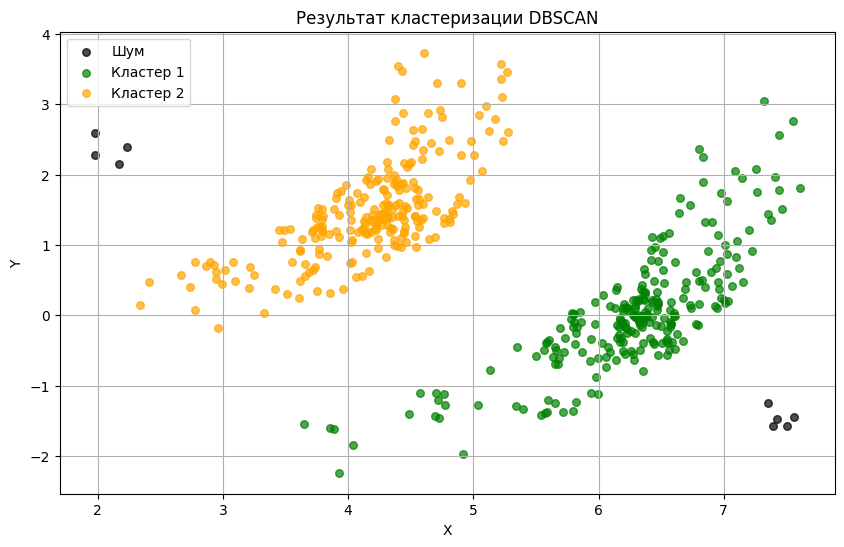

In [ ]:
show_result(labels4, data4, point_size=30)

In [135]:
clusters = cluster_points(data4, labels4)
print("Медоиды кластеров:")
for label, pts in clusters.items():
    med = find_medoid(pts)
    print(f"Кластер {label}: {med}")

centroids = cluster_centroids(clusters)
if centroids:
    avg_x = sum(c[0] for c in centroids) / len(centroids)
    avg_y = sum(c[1] for c in centroids) / len(centroids)
    print(f"Среднее центроидов * 100000: {avg_x*100000:.6f}, {avg_y*100000:.6f}")
else:
    print("Нет кластеров (только шум)")

Медоиды кластеров:
Кластер 1: [6.3167022108860245, 0.004171004482220297]
Кластер 2: [4.244769949421723, 1.4314581166536477]
Среднее центроидов * 100000: 522554.726294, 76715.404491


**Работа с файлом '5.txt'**

In [ ]:
data5 = f('5.txt')
print(data5)

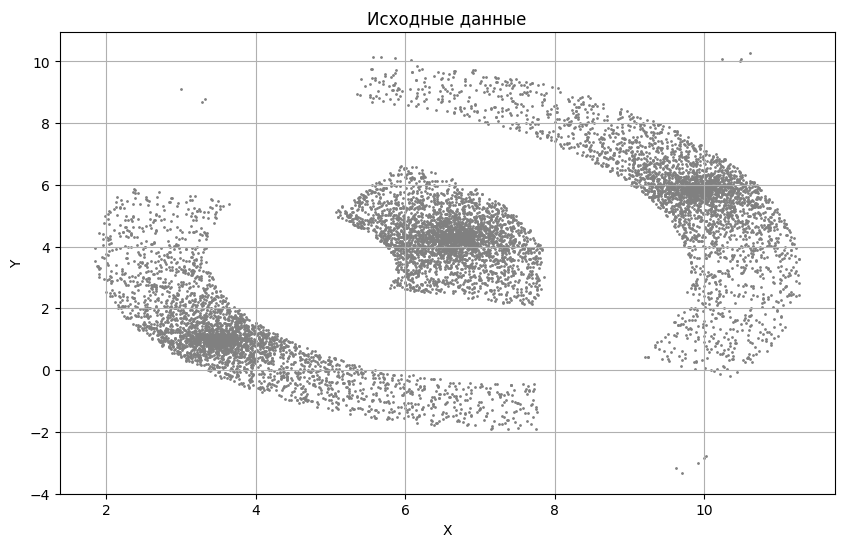

In [ ]:
show_data(data5)

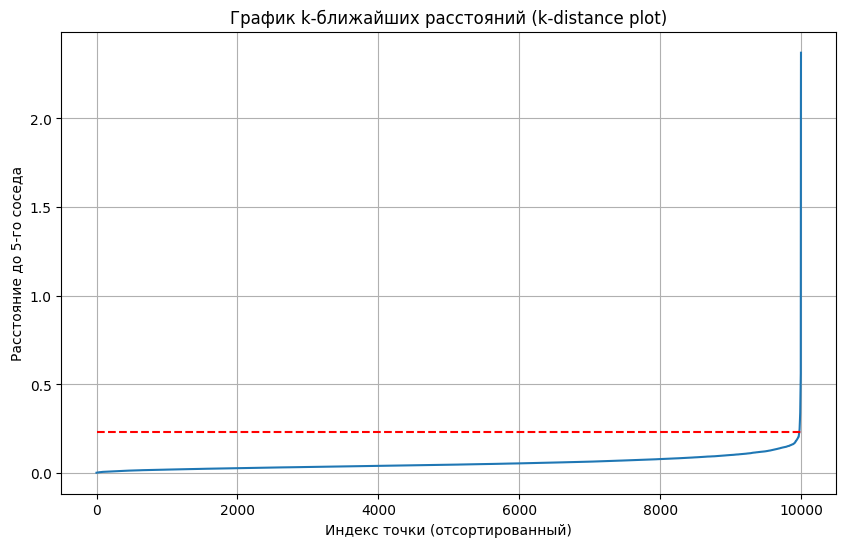

In [116]:
x_coord = [0, len(data5)]
y_coord = [0.23, 0.23]
find_parametrs(data5, x_coord, y_coord)

In [ ]:
labels5 = dbscan(data5, 0.2491, 4)
print(labels5)

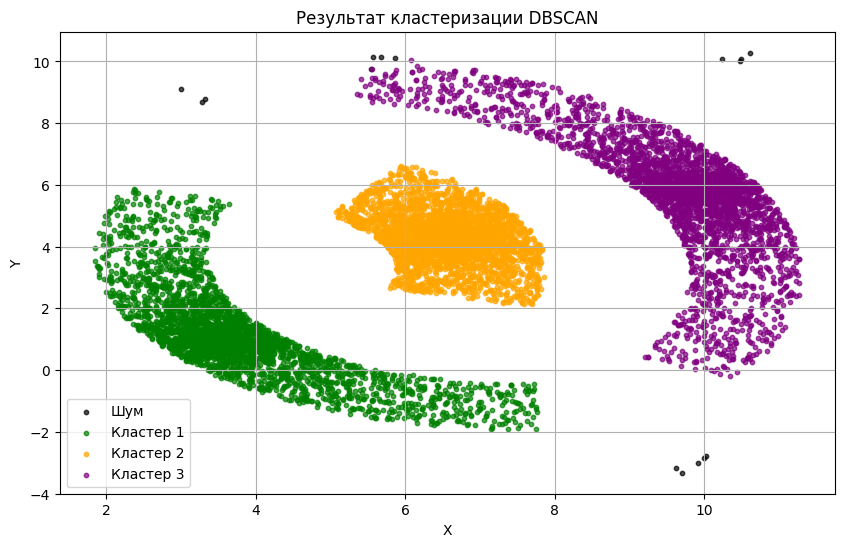

In [161]:
show_result(labels5, data5)

In [ ]:
clusters = cluster_points(data2, labels2)
print("Медоиды кластеров:")
for label, pts in clusters.items():
    med = find_medoid(pts)
    print(f"Кластер {label}: {med}")

centroids = cluster_centroids(clusters)
if centroids:
    avg_x = sum(c[0] for c in centroids) / len(centroids)
    avg_y = sum(c[1] for c in centroids) / len(centroids)
    print(f"Среднее центроидов * 100000: {avg_x*100000:.6f}, {avg_y*100000:.6f}")
else:
    print("Нет кластеров (только шум)")

In [ ]:
# from sklearn.cluster import DBSCAN
# db = DBSCAN(eps=0.67, min_samples=4)

# labels = db.fit_predict(data4)

# Кластеризация (1 за каждый алгоритм на всех данных)

На предложенных распределениях данных проверьте предложенные алгоритмы. Постройте графики кластеризации для каждой пары алгоритм-данные, разные кластеры покрасьте разным цветом. Воспользуйтесь sklearn реализациями. Параметры кластеризации для разных алгоритмов подберите такие, чтобы алгоритмы можно было сравнивать (по возможности одинаковое количество кластеров и т.д.)

In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [3]:
from sklearn.cluster import KMeans, DBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, OPTICS
from sklearn.mixture import GaussianMixture

# подавляем предупреждения для чистоты вывода
warnings.filterwarnings("ignore")

np.random.seed(0)

# генерация датасетов

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# базовые параметры и параметры для каждого датасета
default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets_params = [
    (noisy_circles,
     {"damping": 0.77, "preference": -240, "quantile": 0.2,
      "n_clusters": 2, "min_samples": 20, "xi": 0.25}),
    (noisy_moons,
     {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (varied,
     {"eps": 0.18, "n_neighbors": 2, "min_samples": 5,
      "xi": 0.035, "min_cluster_size": 0.2}),
    (aniso,
     {"eps": 0.15, "n_neighbors": 2, "min_samples": 20,
      "xi": 0.1, "min_cluster_size": 0.2}),
    (blobs, {}),
    (no_structure, {}),
]

In [4]:
# алгоритмы с начальными параметрами
two_means = KMeans(n_clusters=2, n_init='auto')
dbscan = DBSCAN(eps=0.3)
meanshift = MeanShift(bandwidth=None)
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors',
                              assign_labels='kmeans')
ward = AgglomerativeClustering(n_clusters=3, linkage='ward')
average_linkage = AgglomerativeClustering(n_clusters=3, linkage='average')
optics = OPTICS(min_samples=20, xi=0.05, min_cluster_size=0.1)
gmm = GaussianMixture(n_components=3, covariance_type='full')

clustering_algorithms = (
    ("KMeans (2 means)", two_means),
    ("DBSCAN", dbscan),
    ("MeanShift", meanshift),
    ("Spectral\nClustering", spectral),
    ("Ward", ward),
    ("Agglomerative\nClustering", average_linkage),
    ("OPTICS", optics),
    ("Gaussian\nMixture", gmm),
)

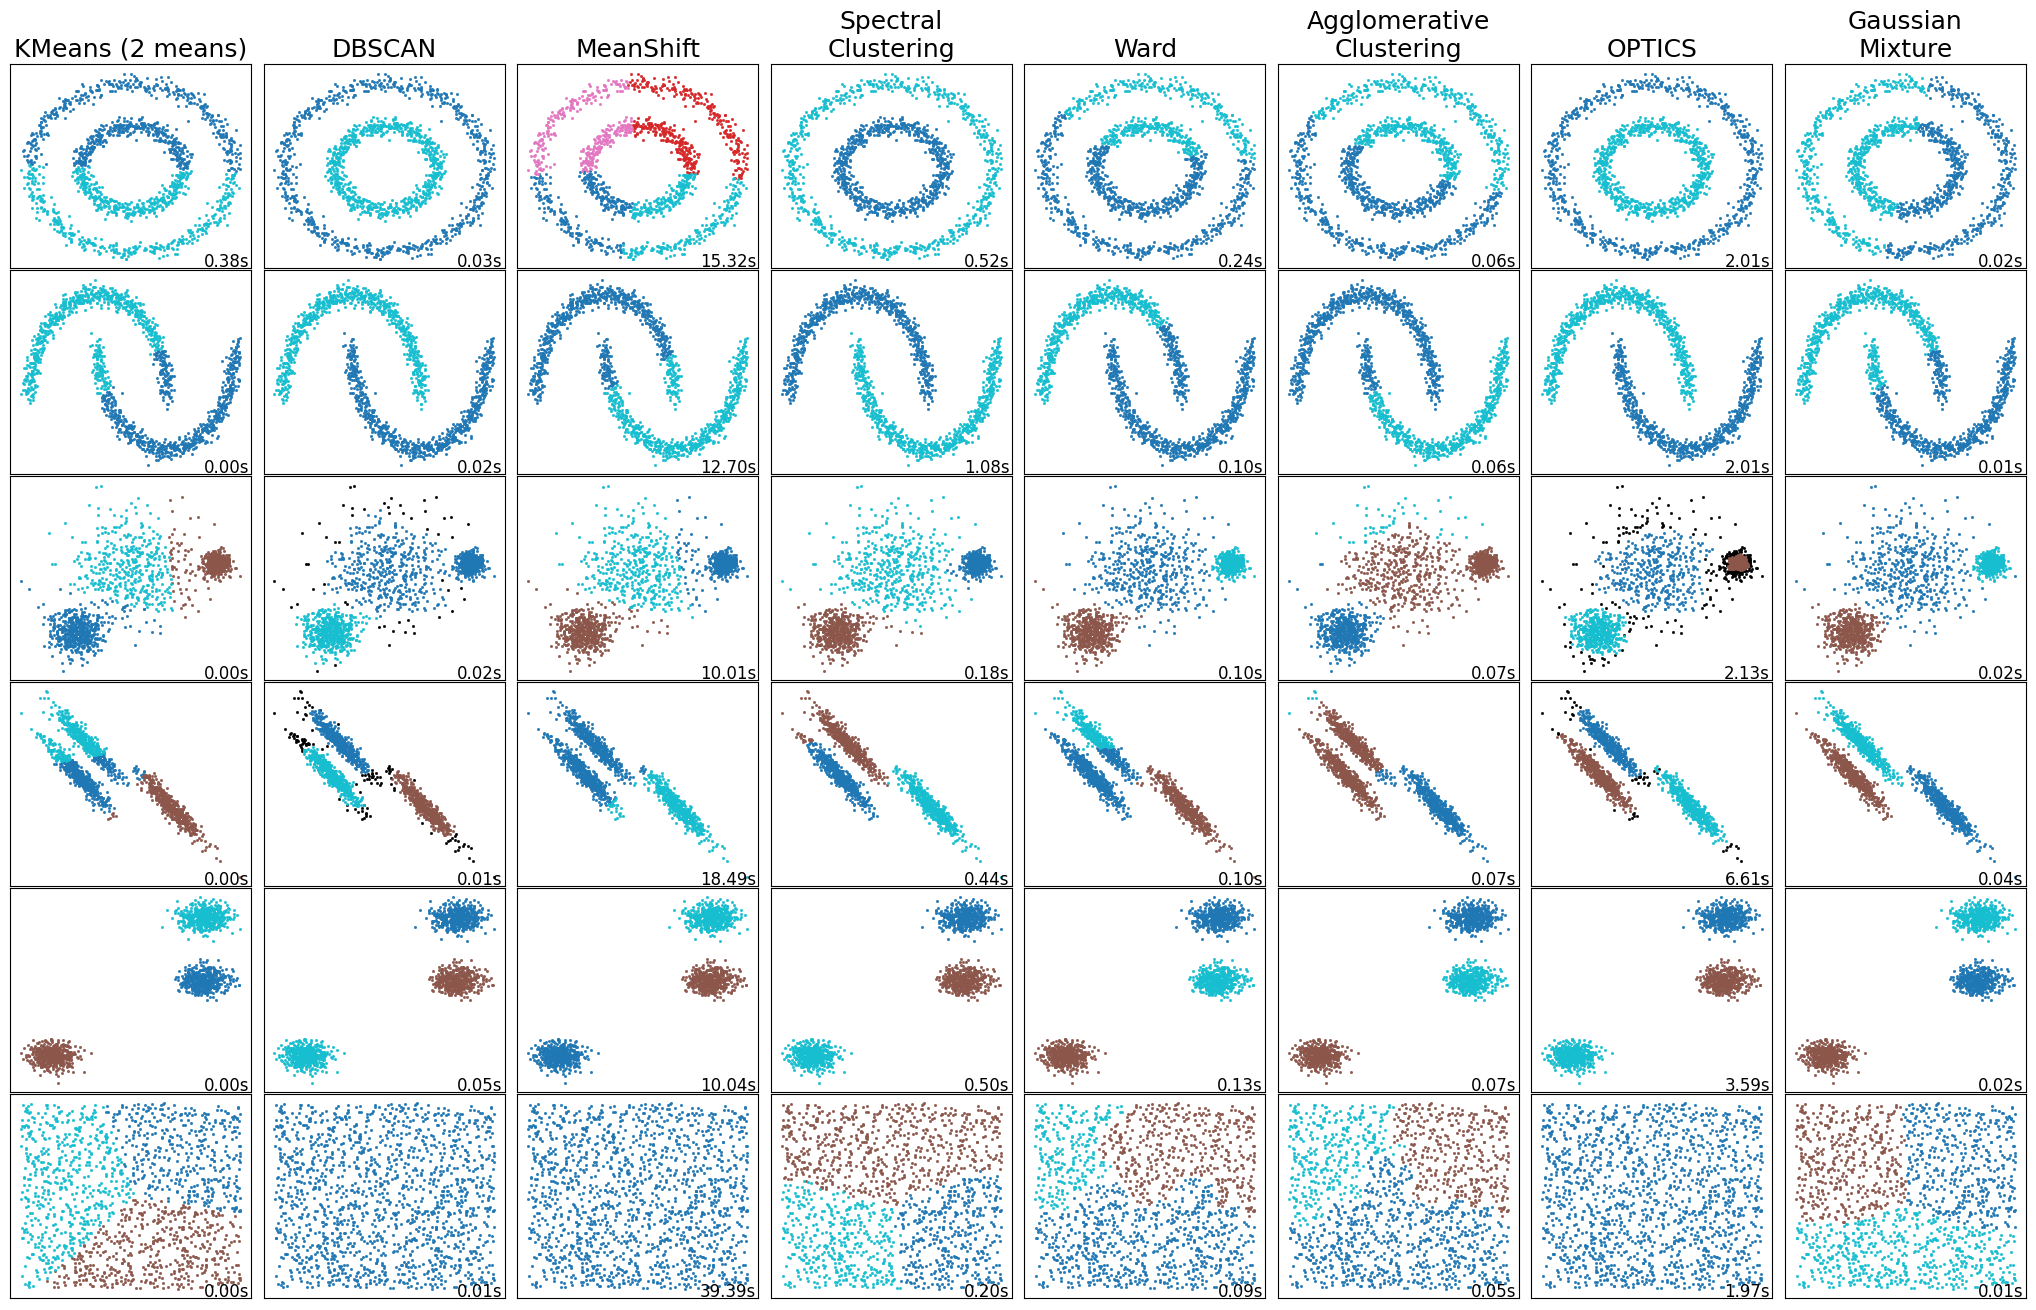

In [5]:
# построение фигуры

plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.95,
                    wspace=0.05, hspace=0.01)

plot_num = 1


for i_dataset, (dataset, algo_params) in enumerate(datasets_params):
    # объединяем базовые параметры с уточнениями для датасета
    params = default_base.copy()
    params.update(algo_params)

    X, y_true = dataset

    # Нормализация
    X = StandardScaler().fit_transform(X)

    # Оценка bandwidth для MeanShift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # матрица связности для иерархических методов
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Перебор алгоритмов
    for name, alg in clustering_algorithms:
        t0 = time.time()

        # Создаём копию объекта, чтобы не изменять исходные экземпляры
        alg_copy = type(alg)(**alg.get_params())

        # Адаптируем параметры под текущий датасет
        # Устанавливаем n_clusters для алгоритмов, которые его поддерживают
        if hasattr(alg_copy, 'n_clusters'):
            alg_copy.set_params(n_clusters=params['n_clusters'])
        if hasattr(alg_copy, 'n_components'):  # для GaussianMixture
            alg_copy.set_params(n_components=params['n_clusters'])
        if hasattr(alg_copy, 'eps'):
            alg_copy.set_params(eps=params['eps'])
        if hasattr(alg_copy, 'min_samples'):
            alg_copy.set_params(min_samples=params['min_samples'])
        if hasattr(alg_copy, 'xi'):
            alg_copy.set_params(xi=params['xi'])
        if hasattr(alg_copy, 'min_cluster_size'):
            alg_copy.set_params(min_cluster_size=params['min_cluster_size'])
        # Для MeanShift обновляем bandwidth
        if isinstance(alg_copy, MeanShift):
            alg_copy.set_params(bandwidth=bandwidth)

        # Выполняем кластеризацию
        if isinstance(alg_copy, GaussianMixture):
            alg_copy.fit(X)
            y_pred = alg_copy.predict(X)
        else:
            y_pred = alg_copy.fit_predict(X)

        elapsed = time.time() - t0

        plt.subplot(len(datasets_params), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # Цветовая схема: для кластеров используем tab10, шум (label = -1) – чёрный
        unique_labels = set(y_pred)
        n_clusters_found = len(unique_labels - {-1})
        colors = plt.cm.tab10(np.linspace(0, 1, n_clusters_found)) if n_clusters_found > 0 else np.array([])
        colors = list(colors)
        # Добавляем чёрный для шума, если он есть
        if -1 in unique_labels:
            colors = [[0, 0, 0, 1]] + colors

        # Отображаем точки
        for k, col in zip(sorted(unique_labels), colors):
            if k == -1:
                # Шумовые точки – чёрные
                class_member_mask = (y_pred == -1)
                plt.scatter(X[class_member_mask, 0], X[class_member_mask, 1],
                            s=10, c=[col], marker='.', linewidth=0.5)
            else:
                class_member_mask = (y_pred == k)
                plt.scatter(X[class_member_mask, 0], X[class_member_mask, 1],
                            s=10, c=[col], marker='.', linewidth=0.5)

        plt.xticks(())
        plt.yticks(())
        plt.text(0.99, 0.01, f'{elapsed:.2f}s',
                 transform=plt.gca().transAxes, size=12,
                 horizontalalignment='right')

        plot_num += 1

plt.show()